###     TIPP - AAI Assignement (Applied AI Solutions Development – Computer Vision)<br>Due Date: 6 March 2020
###     Submitted By: <u>KOAY</u> SENG TIAN<br>Email: sengtian@yahoo.com


In [0]:
# TIPP - AAI Assignment (Applied AI Solutions Development – Computer Vision)
# Date Due: 6 March 2020
# Submited By: KOAY SENG TIAN
# Email: sengtian@yahoo.com
#
# GitHub: https://github.com/koayst/rp_computer_vision_assignment
# 
# The following script took inspiration from Adrian Rosebrock's web site - 
# 'Change input shape dimensions for fine-tuning with Keras' i.e. 
# https://www.pyimagesearch.com/2019/06/24/change-input-shape-dimensions-for-fine-tuning-with-keras/
# In his web site, the model was used to classify Kaggle's cats and dogs.  
# For the assignment, it is about classifying 76 species of birds.
#
# (Google colab directory structure)
# TIPP_AAI_AAISD_CV 
#        |--- clean_dataset
#        |          |--- Amur_Asian_Paradise_Flycatcher (images of bird for training)
#        |          |         .
#        |          |         . (total 77 directories)
#        |          |         .
#        |          |--- Zitting_Cisticola
#        |
#        |--- test_bird (images if bird for testing)
#        |--- question_1_cv_colab.ipynb
#        |--- question_2_cv_colab.ipynb
#        |--- bird_cv_model.h5
#        |--- bird_cv_labels.pkl


In [1]:
# At the beginning, it was intended to run this jupyter notebook in google's colab.
# This is because running under a GPU setup is faster when compared to running
# it under a CPU setup.  At the moment, it is excuting like 7-10s per epoch.
#
# May need to change the below according to your google drive account configuration
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# google colab specifics
%tensorflow_version 1.x

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.pooling import AveragePooling2D
from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
import keras.utils 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from imutils import paths

import matplotlib.pyplot as plt

import numpy as np
from numpy.random import seed

import cv2
import os

# for reproducibility
np.random.seed(42)


Using TensorFlow backend.


In [3]:
import random

images_dir = 'gdrive/My Drive/TIPP_AAI_AAISD_CV/clean_dataset'
script_dir = 'gdrive/My Drive/TIPP_AAI_AAISD_CV'
model_name = 'bird_cv_model.h5'
label_name = 'bird_cv_labels.pkl'

imagePaths = sorted(list(paths.list_images(images_dir)))
random.shuffle(imagePaths)

data = []
labels = []

# size is 224 x 224 pixels as required by VGG 16 model
img_size = 224

# estimated number of epochs to run
num_epochs = 75

print("Load images.")


Load images.


In [4]:
import tqdm

# loop over the image paths and load the images into array
for imagePath in tqdm.tqdm(imagePaths):
	# extract the class label from the directory name
	label = imagePath.split(os.path.sep)[-2]

	# load the image and resize it 
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (img_size, img_size))

	# update the data and labels lists
	data.append(image)
	labels.append(label)

# convert the data and labels to numpy array
data = np.array(data)
labels = np.array(labels)


100%|██████████| 954/954 [00:10<00:00, 87.25it/s]


In [5]:
print('Total rows of data: {}'.format(len(data)))
print('Total rows of labels: {}'.format(len(labels)))


Total rows of data: 954
Total rows of labels: 954


In [6]:
# the labels are the bird names so need to One-Hot encoding on the categories
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = keras.utils.to_categorical(labels)

# create a dictionary, mapping the label name to its number encoded
lb_name_mapping = dict(zip(lb.transform(lb.classes_), lb.classes_))

# record the number of unique labels
img_classes=len(lb_name_mapping)

print('Number of unique labels(classes): {}'.format(img_classes))


Number of unique labels(classes): 77


In [7]:
print(labels.shape)
print(img_classes)

(954, 77)
77


In [0]:
# split the data into training and testing using 75% of the data for training 
# and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, stratify=labels, random_state=42)


In [0]:
# initialize the training data augmentation variable
# this is because there are imbalances in the dataset
# some bird species have few images while some 
# have many images.
train_datagen = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	vertical_flip=True,
	fill_mode="nearest")

# initialize the validation/testing data augmentation variables 
test_datagen = ImageDataGenerator()

# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation variables
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
train_datagen.mean = mean
test_datagen.mean = mean

In [10]:
# load VGG16, ensuring the head fully connected layer sets are left off
# adjust the size of the input image tensor to the network
baseModel = VGG16(weights="imagenet", 
                  include_top=False, 
                  input_tensor=Input(shape=(img_size, img_size, 3)))

print("Summary.")
print(baseModel.summary())

# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(img_size, activation="relu")(headModel)
headModel = Dropout(rate=0.5)(headModel)
headModel = Dense(img_classes, activation="softmax")(headModel)

# place the head fully connected model on top of the base model 
# (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False





58892288/58889256 [==============================] - 2s 0us/step






Summary.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________

In [11]:
# compile the model 
print("Compiling model.")
model.compile(loss="categorical_crossentropy", optimizer='sgd', metrics=["accuracy"])

callbacks_list = [
	        #keras.callbacks.EarlyStopping(monitor='acc', patience=1),
			keras.callbacks.ModelCheckpoint(filepath=os.path.join(script_dir, model_name), monitor='val_loss', save_best_only=True)
]

# train the head of the network for a few epochs 
# (all other layers are frozen) 
print("Training.")
history = model.fit_generator(
	train_datagen.flow(trainX, trainY, batch_size=32), steps_per_epoch=len(trainX) // 32,
	validation_data=test_datagen.flow(testX, testY), validation_steps=len(testX) // 32,
	epochs=num_epochs,
	callbacks= callbacks_list)

Compiling model.


Training.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/75
22/22 [==============================] - 12s 533ms/step - loss: 11.2343 - acc: 0.0438 - val_loss: 6.1410 - val_acc: 0.1429
Epoch 2/75
22/22 [==============================] - 8s 368ms/step - loss: 5.2263 - acc: 0.0868 - val_loss: 3.7898 - val_acc: 0.2222
Epoch 3/75
22/22 [==============================] - 7s 326ms/step - loss: 4.0599 - acc: 0.1576 - val_loss: 3.3261 - val_acc: 0.2560
Epoch 4/75
22/22 [==============================] - 7s 336ms/step - loss: 3.7436 - acc: 0.2038 - val_loss: 3.0527 - val_acc: 0.3382
Epoch 5/75
22/22 [==============================] - 7s 316ms/step - loss: 3.5352 - acc: 0.2532 - val_loss: 2.8554 - val_acc: 0.3671
Epoch 6/75
22/22 [==============================] - 8s 361ms/step - loss: 3.2919 - acc: 0.2812 - val_loss: 2.4882 - val_acc: 0.4686
Epoch 7/75
22/22 [==============================] - 7s 307ms/step - loss: 3.1515 

In [0]:
# Save the model in case it is not saved, the script is commented out for now
# print('Save model.')
# model.save(os.path.join(script_dir, model_name))


In [12]:
# save the label encoder so that later the label name and its number mapping
# can be retrieved
import pickle
with open(os.path.join(script_dir, label_name), 'wb+') as encoder_file:
    pickle.dump(lb, encoder_file)
    print('Save LabelEncoder.')


Save LabelEncoder.


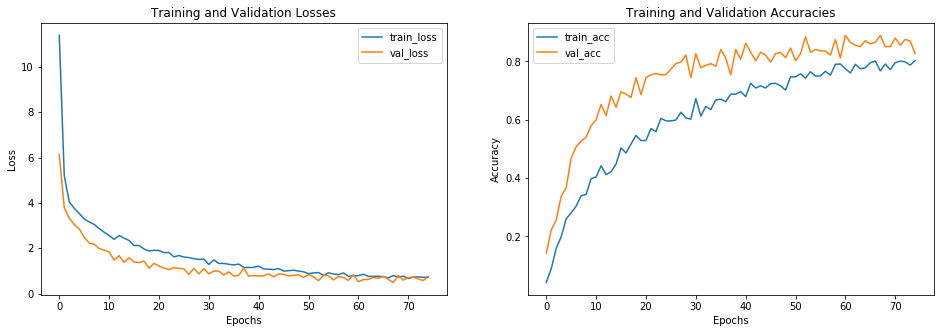

In [13]:
# Validation
predictions = model.predict(testX, batch_size=32)

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
ax1.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
ax1.title.set_text('Training and Validation Losses')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(np.arange(0, num_epochs), history.history["acc"], label="train_acc")
ax2.plot(np.arange(0, num_epochs), history.history["val_acc"], label="val_acc")
ax2.title.set_text('Training and Validation Accuracies')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print('Accuracy  = {:.2f}'.format(accuracy_score(testY.argmax(axis=1), predictions.argmax(axis=1))))


Accuracy  = 0.85
